In [2]:
!pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

print("Các thư viện cần thiết đã được cài đặt và nhập.")

Các thư viện cần thiết đã được cài đặt và nhập.


In [8]:
# Tải dữ liệu đã xử lý từ Phần 2
filename = "KO_processed_final.csv"
df_processed = pd.read_csv(filename, index_col='Date', parse_dates=True)
print("Đã tải dữ liệu.")

# Chuẩn bị dữ liệu
target_column = 'Close'
series = df_processed[target_column].copy()
lag = 3
df_for_models = series.to_frame(name=target_column)
for i in range(1, lag + 1):
    df_for_models[f'lag_{i}'] = df_for_models[target_column].shift(i)
df_for_models.dropna(inplace=True)

X = df_for_models.drop(target_column, axis=1)
y = df_for_models[target_column]

train_size_aligned = int(len(df_for_models) * 0.8)
test_set_aligned = df_for_models[train_size_aligned:]

X_train = X[:train_size_aligned]
y_train = y[:train_size_aligned]
X_test = X[train_size_aligned:]
y_test = y[train_size_aligned:]

train_arima = series[series.index < y_test.index[0]]

print("Dữ liệu cho mô hình đã sẵn sàng.")

Đã tải dữ liệu.
Dữ liệu cho mô hình đã sẵn sàng.


In [9]:
# Huấn luyện và Đánh giá
results = {}
predictions_df = pd.DataFrame(index=y_test.index)
predictions_df['Actual'] = y_test

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    results[model_name] = {'MAE': mae, 'MAPE (%)': mape}
    predictions_df[model_name] = y_pred
    print(f"{model_name} -> MAE: {mae:.4f}, MAPE: {mape:.2f}%")

# -- Mô hình 1: ARIMA --
print("\n--- Mô hình ARIMA ---")
model_arima = ARIMA(train_arima, order=(1, 1, 0))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.predict(start=len(train_arima), end=len(train_arima) + len(y_test) - 1)
forecast_arima.index = y_test.index
evaluate_model(y_test, forecast_arima, 'ARIMA')

# -- Mô hình 2: Random Forest --
print("\n--- Mô hình RandomForest ---")
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
evaluate_model(y_test, predictions_rf, 'RandomForest')

# -- Các mô hình khác... --
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)
print("\n--- Mô hình Linear Regression ---")
evaluate_model(y_test, predictions_lr, 'LinearRegression')

model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)
predictions_dt = model_dt.predict(X_test)
print("\n--- Mô hình Decision Tree ---")
evaluate_model(y_test, predictions_dt, 'DecisionTree')

model_svr = SVR(kernel='rbf')
model_svr.fit(X_train, y_train)
predictions_svr = model_svr.predict(X_test)
print("\n--- Mô hình SVR ---")
evaluate_model(y_test, predictions_svr, 'SVR')

# So sánh
results_summary_df = pd.DataFrame(results).T.sort_values(by='MAE')
print("\n--- Bảng Tổng hợp Hiệu suất Mô hình ---")
print(results_summary_df)


--- Mô hình ARIMA ---
ARIMA -> MAE: 0.3630, MAPE: 0.51%

--- Mô hình RandomForest ---
RandomForest -> MAE: 0.5847, MAPE: 0.82%

--- Mô hình Linear Regression ---
LinearRegression -> MAE: 0.6050, MAPE: 0.84%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)



--- Mô hình Decision Tree ---
DecisionTree -> MAE: 1.1100, MAPE: 1.55%

--- Mô hình SVR ---
SVR -> MAE: 0.5707, MAPE: 0.80%

--- Bảng Tổng hợp Hiệu suất Mô hình ---
                       MAE  MAPE (%)
ARIMA             0.362998  0.508274
SVR               0.570720  0.795611
RandomForest      0.584700  0.815867
LinearRegression  0.605024  0.843579
DecisionTree      1.110001  1.549176



=> Mô hình tốt nhất là: ARIMA


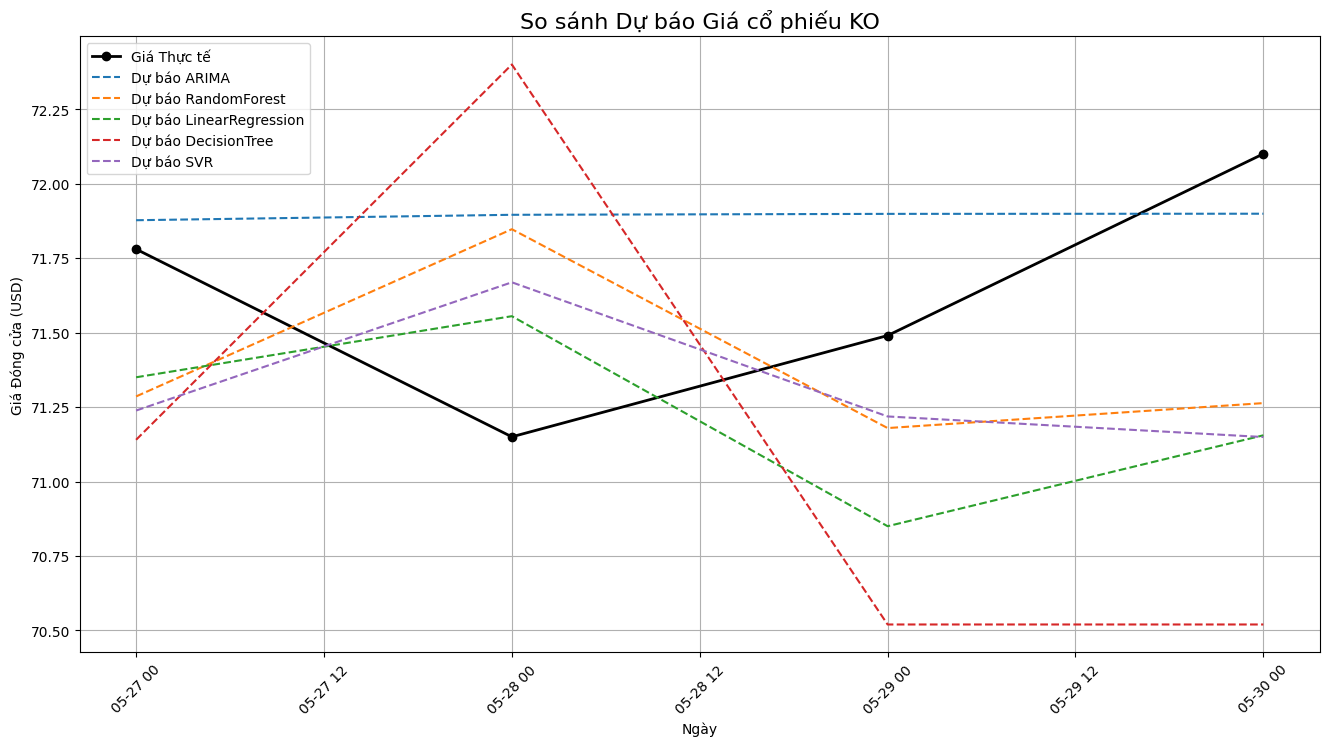

In [11]:
# Trực quan hóa kết quả dự báo
best_model_name = results_summary_df.idxmin()['MAE']
print(f"\n=> Mô hình tốt nhất là: {best_model_name}")

plt.figure(figsize=(16, 8))
plt.plot(predictions_df.index, predictions_df['Actual'], label='Giá Thực tế', marker='o', color='black', lw=2)

# Define ticker_symbol
ticker_symbol = "KO" # Replace with the actual ticker symbol

for model in predictions_df.columns[1:]: # Bỏ qua cột 'Actual'
    plt.plot(predictions_df.index, predictions_df[model], label=f'Dự báo {model}', linestyle='--')

plt.title(f'So sánh Dự báo Giá cổ phiếu {ticker_symbol}', fontsize=16)
plt.xlabel('Ngày')
plt.ylabel('Giá Đóng cửa (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()